## Importing and prepping data

In [1]:
import pandas as pd
import numpy as np
import diff_classifier.aws as aws
import diff_classifier.pca as pca

In [ ]:
features = []
featofvar = 'Coverage'

remote_folder = '10_05_18_coverage' #Folder in AWS S3 containing files to be analyzed
bucket = 'evanepst.data'
vids = 10
types = ['0_10xs', '0_15xs', '0_20xs', '0_25xs', '0_40xs', '0_50xs', '0_60xs', '0_75xs', '1xs', 'PSCOOH']
low = ['0_10xs', '0_15xs', '0_20xs', '0_25xs', '0_40xs', 'PSCOOH']
verylow = ['0_10xs', '0_15xs', 'PSCOOH']
coverage = [10, 15, 20, 25, 40, 50, 60, 75, 100, 0]

counter2 = 0
counter = 0
for typ in types:
    for num in range(1, vids+1):
            try:
                filename = 'features_5mM_{}_XY{}.csv'.format(typ, '%02d' % num)
                print(filename)
                aws.download_s3('{}/{}'.format(remote_folder, filename), filename, bucket_name=bucket)
                fstats = pd.read_csv(filename, encoding = "ISO-8859-1", index_col='Unnamed: 0')
                print('{} size: {}'.format(filename, fstats.shape))
                fstats['Coverage'] = pd.Series(fstats.shape[0]*[typ], index=fstats.index)
                fstats['Coverage Int'] = pd.Series(fstats.shape[0]*[coverage[counter2]], index=fstats.index)
                if typ in low:
                    fstats['Bin Coverage'] = pd.Series(fstats.shape[0]*['lo'], index=fstats.index)
                else:
                    fstats['Bin Coverage'] = pd.Series(fstats.shape[0]*['hi'], index=fstats.index)
                if typ in verylow:
                    fstats['Bin Coverage 2'] = pd.Series(fstats.shape[0]*['lo'], index=fstats.index)
                else:
                    fstats['Bin Coverage 2'] = pd.Series(fstats.shape[0]*['hi'], index=fstats.index)
                fstats['Video Number'] = pd.Series(fstats.shape[0]*[num], index=fstats.index)
                counter = counter + 1
                if counter == 1:
                    fstats_tot = fstats
                else:
                    fstats_tot = fstats_tot.append(fstats, ignore_index=True)
            except:
                print('Skipped!: {}'.format(filename))
    counter2 = counter2 + 1

features_5mM_0_10xs_XY01.csv
features_5mM_0_10xs_XY01.csv size: (49211, 67)
features_5mM_0_10xs_XY02.csv
features_5mM_0_10xs_XY02.csv size: (44017, 67)
features_5mM_0_10xs_XY03.csv
features_5mM_0_10xs_XY03.csv size: (31060, 67)
features_5mM_0_10xs_XY04.csv
features_5mM_0_10xs_XY04.csv size: (35683, 67)
features_5mM_0_10xs_XY05.csv
features_5mM_0_10xs_XY05.csv size: (33176, 67)
features_5mM_0_10xs_XY06.csv
features_5mM_0_10xs_XY06.csv size: (28024, 67)
features_5mM_0_10xs_XY07.csv
features_5mM_0_10xs_XY07.csv size: (32077, 67)
features_5mM_0_10xs_XY08.csv
features_5mM_0_10xs_XY08.csv size: (19282, 67)
features_5mM_0_10xs_XY09.csv
features_5mM_0_10xs_XY09.csv size: (14535, 67)
features_5mM_0_10xs_XY10.csv
features_5mM_0_10xs_XY10.csv size: (15370, 67)
features_5mM_0_15xs_XY01.csv
features_5mM_0_15xs_XY01.csv size: (21450, 67)
features_5mM_0_15xs_XY02.csv
features_5mM_0_15xs_XY02.csv size: (48430, 67)
features_5mM_0_15xs_XY03.csv
features_5mM_0_15xs_XY03.csv size: (54075, 67)
features_5mM

In [ ]:
#PCA analyses with too many datapoints fail. You get rows with lots of NAs. I'm going to try making a subset of the data first
#and then do a PCA analysis on that.

#include all in analysis
import random
subset = np.sort(np.array(random.sample(range(fstats_tot.shape[0]), 500000)))
fstats_sub = fstats_tot.loc[subset, :].reset_index(drop=True)

In [ ]:
fstats_tot[featofvar].unique()

In [ ]:
for typ in fstats_tot[featofvar].unique():
    fstats_type = fstats_tot[fstats_tot[featofvar]==typ].reset_index(drop=True)
    print(fstats_type.shape)

In [ ]:
#with equal sample sizes for each particle type
import random
counter = 0
for typ in fstats_tot[featofvar].unique():
    fstats_type = fstats_tot[fstats_tot[featofvar]==typ].reset_index(drop=True)
    print(fstats_type.shape)
    subset = np.sort(np.array(random.sample(range(fstats_type.shape[0]), 100000)))
    if counter == 0:
        fstats_sub = fstats_type.loc[subset, :].reset_index(drop=True)
    else:
        fstats_sub = fstats_sub.append(fstats_type.loc[subset, :].reset_index(drop=True), ignore_index=True)
    counter = counter + 1

In [ ]:
#fstats = pd.read_csv(filename, encoding = "ISO-8859-1", index_col='Unnamed: 0')
nonnum = ['Coverage', 'Coverage Int', 'Bin Coverage', 'Bin Coverage 2', 'Video Number', 'Track_ID', 'Mean Mean_Intensity', 'Std Mean_Intensity', 'X', 'Y',
          'Mean X', 'Mean Y', 'Std X', 'Std Y']
fstats_num = fstats_sub.drop(nonnum, axis=1)
fstats_raw = fstats_num.as_matrix()
#fstats

## PCA analysis

The pca.pca_analysis function provides a completely contained PCA analysis of the input trajectory features dataset. It includes options to impute NaN values (fill in with average values or drop them), and to scale features. Read the docstring for more information. 

In [ ]:
ncomp = 15
pcadataset = pca.pca_analysis(fstats_tot, dropcols=nonnum, n_components=ncomp)

In [24]:
pcadataset.components.to_csv('components.csv')

In [ ]:
fstats_num.columns

In [12]:
pcadataset.prcomps

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,Mean fractal_dim,Mean asymmetry2,asymmetry3,Std straightness,Std Deff1,trappedness,Quality,Mean SN_Ratio,Std alpha,D_fit,Mean_Intensity,Std alpha,Std MSD_ratio,Std efficiency,Deff2,kurtosis,Std Quality,Deff2,MSD_ratio,SN_Ratio
1,Std fractal_dim,Mean asymmetry1,efficiency,Std efficiency,Std asymmetry2,boundedness,straightness,Std SN_Ratio,Mean alpha,kurtosis,boundedness,Mean alpha,Mean MSD_ratio,Std alpha,Std Deff2,Deff2,Std kurtosis,Std Deff2,Deff2,MSD_ratio
2,Mean Deff1,Mean asymmetry3,asymmetry2,Mean straightness,Mean D_fit,alpha,SN_Ratio,frames,Mean_Intensity,alpha,trappedness,Std SN_Ratio,Std SN_Ratio,Mean_Intensity,kurtosis,Std Quality,kurtosis,Mean Deff2,SN_Ratio,kurtosis
3,Std frames,Mean elongation,straightness,Mean trappedness,Std elongation,MSD_ratio,frames,trappedness,Mean Quality,Deff1,Mean Quality,Mean SN_Ratio,Mean SN_Ratio,Std straightness,Mean Deff2,SN_Ratio,Mean kurtosis,Std Deff1,efficiency,frames
4,Mean efficiency,Mean AR,asymmetry1,Mean boundedness,Std D_fit,asymmetry2,Mean Quality,boundedness,kurtosis,SN_Ratio,D_fit,Std AR,SN_Ratio,Std Quality,Std trappedness,efficiency,Std MSD_ratio,Std kurtosis,Deff1,D_fit


The pca.kmo function calculates the Kaiser-Meyer-Olkin statistic, a measure of sampling adequacy. Check the docstring for more information.

In [25]:
kmostat = pca.kmo(pcadataset.scaled)

0.879774130894


In [ ]:
import scipy.stats as stat
stat.bartlett(pcadataset.scaled[0, :], pcadataset.scaled[1, :], pcadataset.scaled[2, :], pcadataset.scaled[3, :])

In [ ]:
newstr = ''
for i in range(pcadataset.scaled.shape[0]-1):
    newstr = newstr + 'pcadataset.scaled[{}, :], '.format(i)

newstr = 'stat.bartlett(' + newstr + 'pcadataset.scaled[{}, :])'.format(i+1)

In [ ]:
test = eval(newstr)

In [ ]:
test

## Visualization

Users can then compare average principle component values between subgroups of the data. In this case, all particles were taken from the same sample, so there are no experimental subgroups. I chose to compare short trajectories to long trajectories, as I would expect differences between the two groups.

In [15]:
import numpy as np
featofvar = 'Coverage'
#ncomp = 14
dicti = {}
#test = np.exp(np.nanmean(np.log(pcadataset.final[pcadataset.final['Particle Size']==200].as_matrix()), axis=0))[-6:]
#test1 = np.exp(np.nanmean(np.log(pcadataset.final[pcadataset.final['Particle Size']==500].as_matrix()), axis=0))[-6:]
dicti[0] = np.nanmean(pcadataset.final[pcadataset.final[featofvar]=='0_10xs'].values[:, -ncomp:], axis=0)
dicti[1] = np.nanmean(pcadataset.final[pcadataset.final[featofvar]=='0_15xs'].values[:, -ncomp:], axis=0)
dicti[2] = np.nanmean(pcadataset.final[pcadataset.final[featofvar]=='0_20xs'].values[:, -ncomp:], axis=0)
dicti[3] = np.nanmean(pcadataset.final[pcadataset.final[featofvar]=='0_25xs'].values[:, -ncomp:], axis=0)
dicti[4] = np.nanmean(pcadataset.final[pcadataset.final[featofvar]=='0_40xs'].values[:, -ncomp:], axis=0)
dicti[5] = np.nanmean(pcadataset.final[pcadataset.final[featofvar]=='0_50xs'].values[:, -ncomp:], axis=0)
dicti[6] = np.nanmean(pcadataset.final[pcadataset.final[featofvar]=='0_60xs'].values[:, -ncomp:], axis=0)
dicti[7] = np.nanmean(pcadataset.final[pcadataset.final[featofvar]=='0_75xs'].values[:, -ncomp:], axis=0)
dicti[8] = np.nanmean(pcadataset.final[pcadataset.final[featofvar]=='1xs'].values[:, -ncomp:], axis=0)
dicti[9] = np.nanmean(pcadataset.final[pcadataset.final[featofvar]=='PSCOOH'].values[:, -ncomp:], axis=0)

In [17]:
dict1 = {}
dict2 = {}
counter = 0
for i in range(0, 9, 2):
    dict1[counter] = dicti[i]
    dict2[counter] = dicti[i+1]
    counter = counter + 1

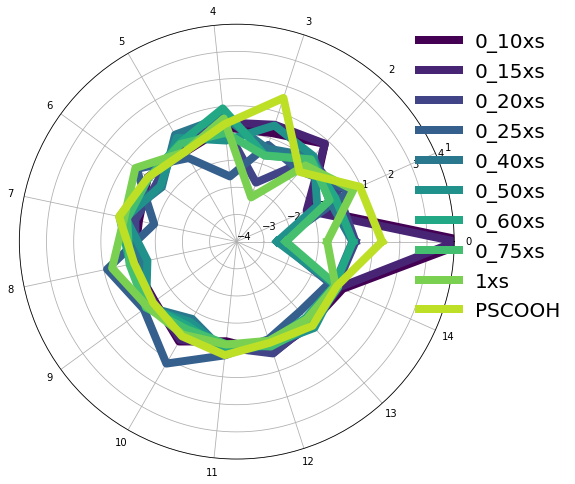

In [18]:
labels = types
pca.plot_pca(dicti, savefig=True, labels=labels, rticks=np.linspace(-4, 4, 9))

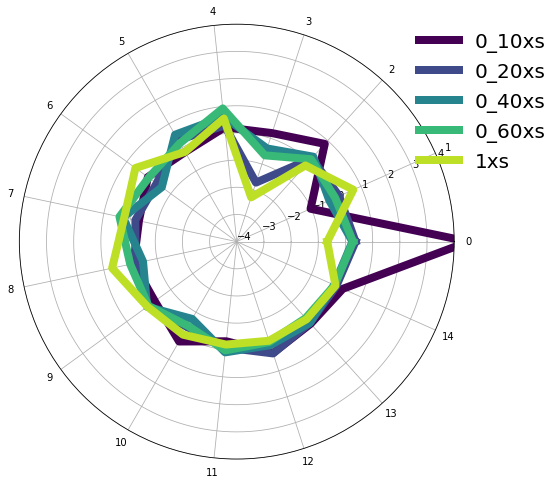

In [21]:
pca.plot_pca(dict1, savefig=True, labels=labels[::2], rticks=np.linspace(-4, 4, 9))

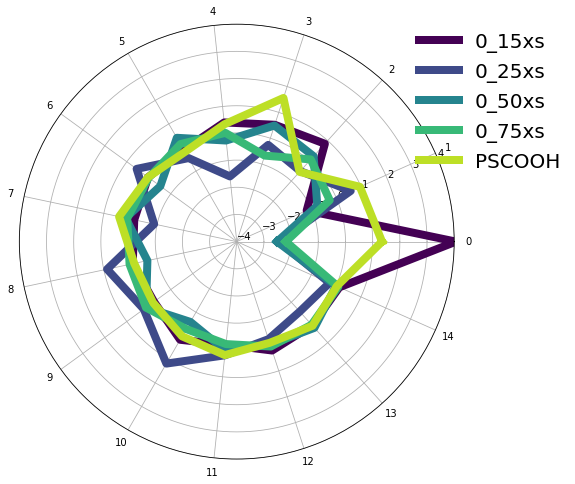

In [22]:
pca.plot_pca(dict2, savefig=True, labels=labels[1::2], rticks=np.linspace(-4, 4, 9))

The variable pcadataset.prcomps shows the user the major contributions to each of the new principle components. When observing the graph above, users can see that there are some differences between short trajectories and long trajectories in component 0 (asymmetry1 being the major contributor) and component 1 (elongation being the major contributor).

In [ ]:
#labels=['10K', '5K', '1K', 'COOH']
feats = pca.feature_violin(pcadataset.final, label=featofvar, lvals=labels, fsubset=ncomp, yrange=[-12, 12])

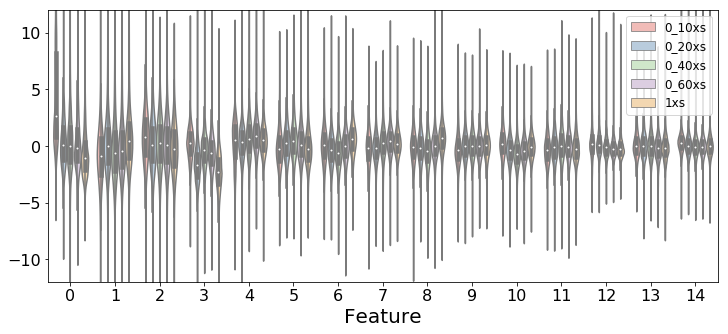

In [23]:
feats = pca.feature_violin(pcadataset.final[pcadataset.final[featofvar].isin(labels[::2])],
                           label=featofvar, lvals=labels[::2], fsubset=ncomp, yrange=[-12, 12])

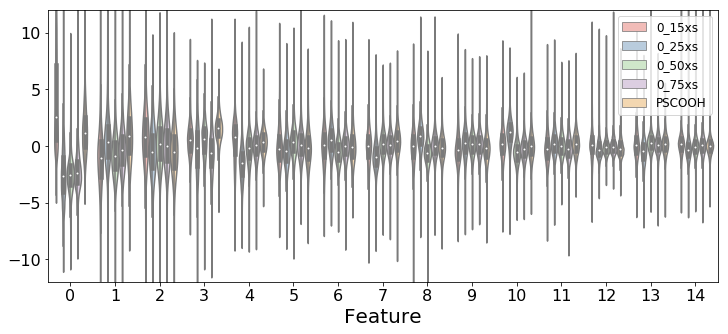

In [24]:
feats = pca.feature_violin(pcadataset.final[pcadataset.final[featofvar].isin(labels[1::2])],
                           label=featofvar, lvals=labels[1::2], fsubset=ncomp, yrange=[-12, 12])

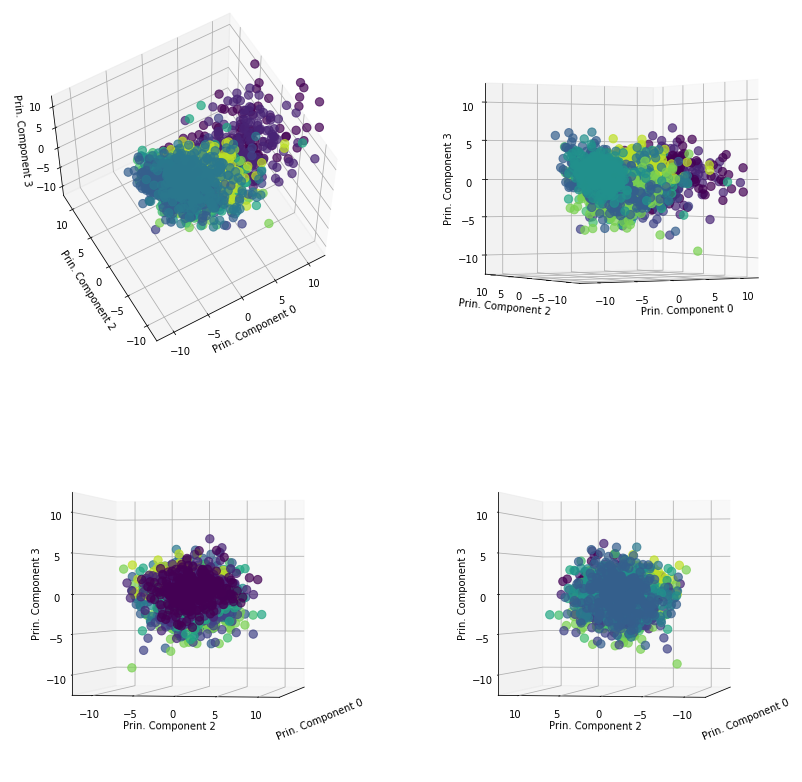

In [25]:
fstats1 = pca.feature_plot_3D(pcadataset.final, label=featofvar, lvals=labels, randcount=300, ylim=[-12, 12],
                              xlim=[-12, 12], zlim=[-12, 12], features=[0, 2, 3])

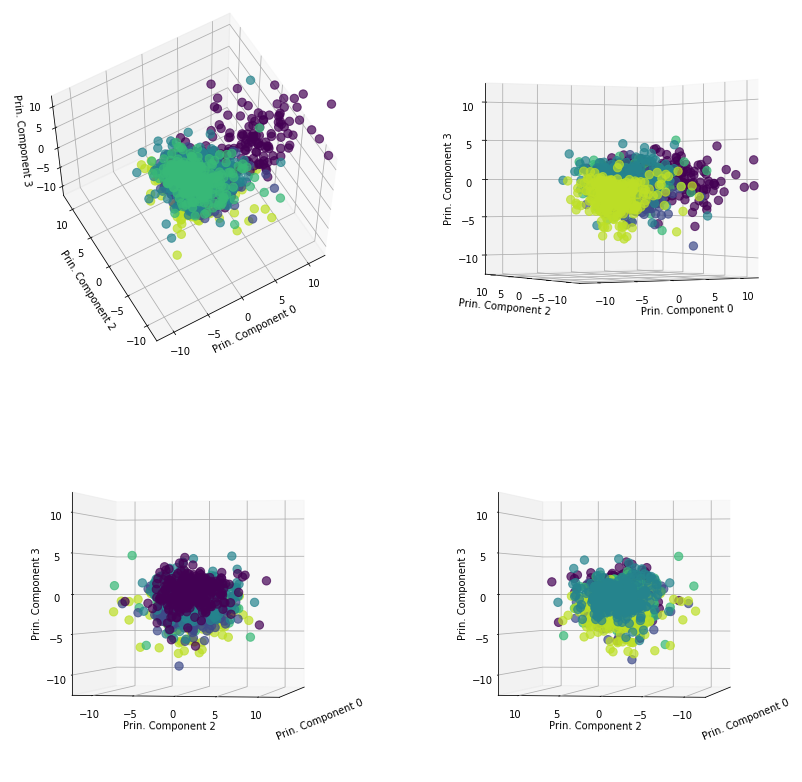

In [26]:
fstats1 = pca.feature_plot_3D(pcadataset.final[pcadataset.final[featofvar].isin(labels[::2])],
                              label=featofvar, lvals=labels[::2], randcount=300, ylim=[-12, 12],
                              xlim=[-12, 12], zlim=[-12, 12], features=[0, 2, 3])

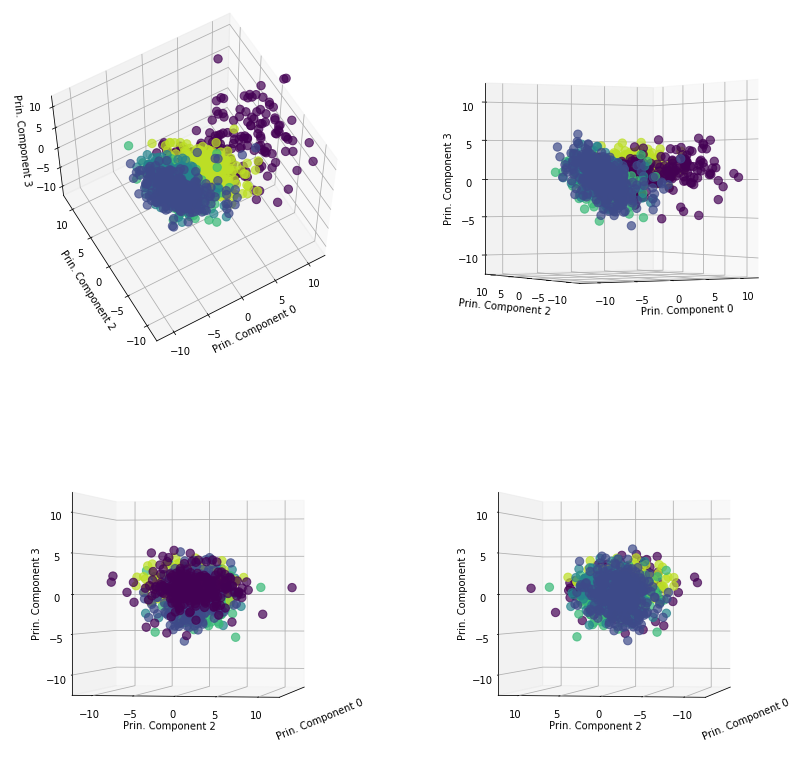

In [27]:
fstats1 = pca.feature_plot_3D(pcadataset.final[pcadataset.final[featofvar].isin(labels[1::2])],
                              label=featofvar, lvals=labels[1::2], randcount=300, ylim=[-12, 12],
                              xlim=[-12, 12], zlim=[-12, 12], features=[0, 2, 3])

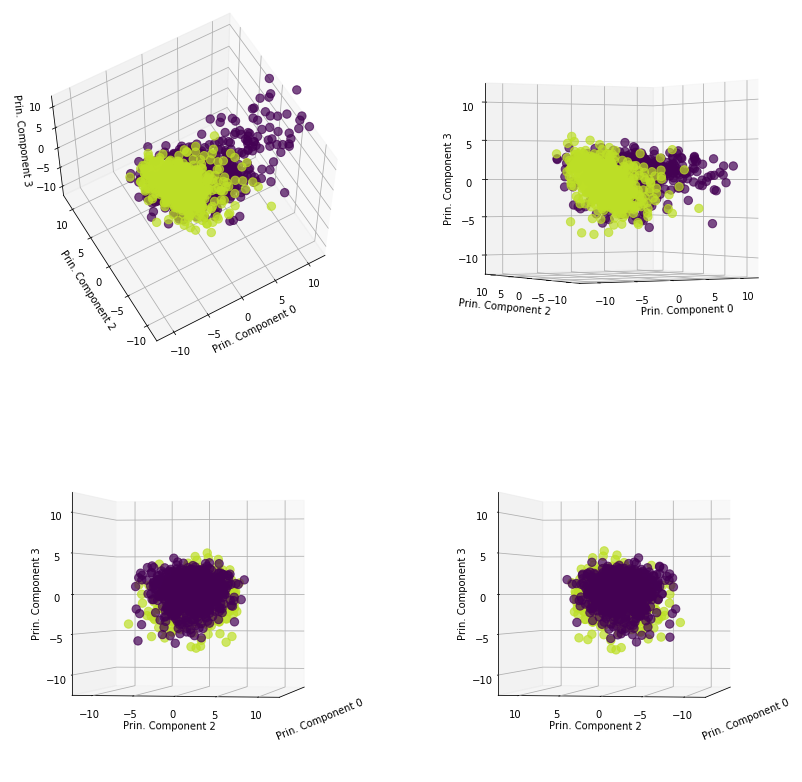

In [23]:
fstats1 = pca.feature_plot_3D(pcadataset.final, label='Bin Coverage', lvals=['lo', 'hi'], randcount=800, ylim=[-12, 12],
                              xlim=[-12, 12], zlim=[-12, 12], features=[0, 2, 3])

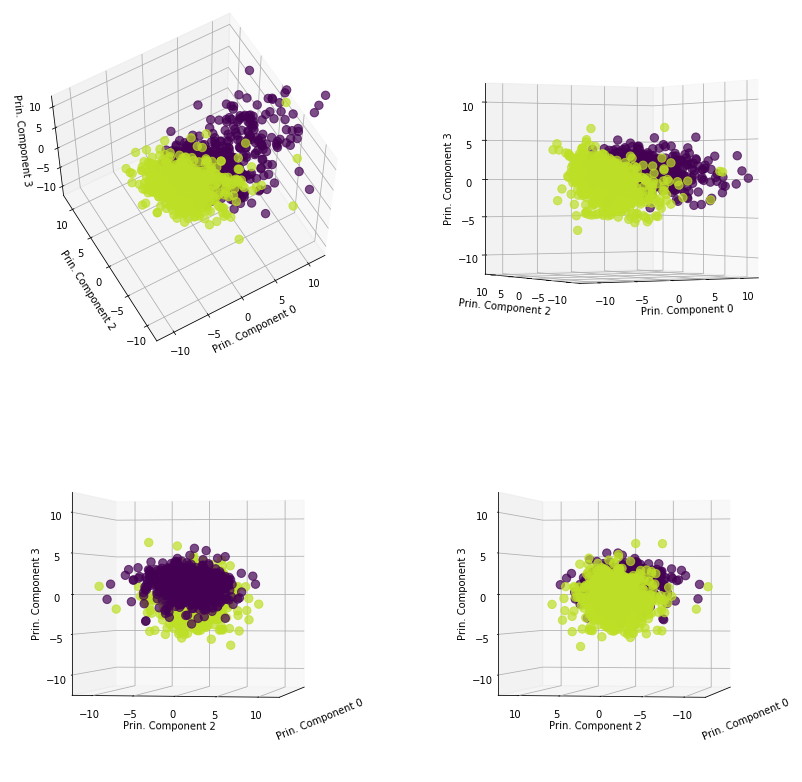

In [29]:
fstats1 = pca.feature_plot_3D(pcadataset.final, label='Bin Coverage 2', lvals=['lo', 'hi'], randcount=800, ylim=[-12, 12],
                              xlim=[-12, 12], zlim=[-12, 12], features=[0, 2, 3])

In [8]:
#ncomp = 14
trainp = np.array([])
testp = np.array([])
labels3 = ['lo', 'hi']

for i in range(0, 20):
    KNNmod, X, y = pca.build_model(pcadataset.final, 'Bin Coverage', labels3, equal_sampling=True,
                                       tsize=3000, input_cols=ncomp, model='MLP', NNhidden_layer=(6, 3))
    trainp = np.append(trainp, pca.predict_model(KNNmod, X, y))
    
    X2 = pcadataset.final.values[:, -ncomp:]
    y2 = pcadataset.final['Bin Coverage'].values
    testp = np.append(testp, pca.predict_model(KNNmod, X2, y2))
    print('Run {}: {}'.format(i, testp[i]))

Run 0: 0.8605643042796935
Run 1: 0.8607101214921239
Run 2: 0.8571607916680323
Run 3: 0.8551157399820798
Run 4: 0.8603737697887844
Run 5: 0.8606445731832981
Run 6: 0.8640544739775992
Run 7: 0.8576948992861345
Run 8: 0.8556340160171181
Run 9: 0.8611059110687207
Run 10: 0.8621799589934224
Run 11: 0.859397488833179
Run 12: 0.8593805462618299
Run 13: 0.8535309151932647
Run 14: 0.8585714690431446
Run 15: 0.8593016660935818
Run 16: 0.8579151527136722
Run 17: 0.863854496086266
Run 18: 0.8486883950052189
Run 19: 0.8573702129597894


In [9]:
print('{} +/ {}'.format(np.mean(trainp), np.std(trainp)))
print('{} +/ {}'.format(np.mean(testp), np.std(testp)))

0.8778499999999999 +/ 0.005547747290567577
0.8586624450963477 +/ 0.0034892645391521302


In [10]:
#ncomp = 14
labels = types
trainp = np.array([])
testp = np.array([])

for i in range(0, 10):
    KNNmod, X, y = pca.build_model(pcadataset.final, featofvar, labels, equal_sampling=True,
                                       tsize=500, input_cols=ncomp, model='MLP', NNhidden_layer=(6, 2))
    trainp = np.append(trainp, pca.predict_model(KNNmod, X, y))
    
    X2 = pcadataset.final.values[:, -ncomp:]
    y2 = pcadataset.final[featofvar].values
    testp = np.append(testp, pca.predict_model(KNNmod, X2, y2))
    print('Run {}: {}'.format(i, testp[i]))

Run 0: 0.5812465732955079
Run 1: 0.5736699109376241
Run 2: 0.5731374698019497
Run 3: 0.5725864196124983
Run 4: 0.5558785445386871
Run 5: 0.5643937142504801
Run 6: 0.5672720071503206
Run 7: 0.5747434033681832
Run 8: 0.5704977616363525
Run 9: 0.5696486888394006


In [11]:
print('{} +/ {}'.format(np.mean(trainp), np.std(trainp)))
print('{} +/ {}'.format(np.mean(testp), np.std(testp)))

0.52682 +/ 0.010150645299684166
0.5703074493431004 +/ 0.006455235396917375


In [21]:
#ncomp = 14
labels = types
trainp = np.array([])
testp = np.array([])

for i in range(0, 10):
    KNNmod, X, y = pca.build_model(pcadataset.final, featofvar, labels, equal_sampling=True,
                                       tsize=700, input_cols=ncomp, model='MLP', NNhidden_layer=(13, 10, 7, 5, 3))
    trainp = np.append(trainp, pca.predict_model(KNNmod, X, y))
    
    X2 = pcadataset.final.values[:, -ncomp:]
    y2 = pcadataset.final[featofvar].values
    testp = np.append(testp, pca.predict_model(KNNmod, X2, y2))
    print('Run {}: {}'.format(i, testp[i]))

Run 0: 0.5779544372594363
Run 1: 0.563786559152627
Run 2: 0.5512451678953272
Run 3: 0.542090902172482
Run 4: 0.5918095721639663
Run 5: 0.5677305675650303
Run 6: 0.6014201763249507
Run 7: 0.6133355256835494
Run 8: 0.5842720721431353
Run 9: 0.5750055966034866


In [22]:
print('{} +/ {}'.format(np.mean(trainp), np.std(trainp)))
print('{} +/ {}'.format(np.mean(testp), np.std(testp)))

0.5317428571428573 +/ 0.018629776472855814
0.5768650576963992 +/ 0.02082306962260384


In [12]:
from sklearn.neural_network import MLPRegressor

In [16]:
def build_modelR(rawdata, feature, featvals, equal_sampling=True,
                    tsize=20, from_end=True, input_cols=6, model='KNN',
                    **kwargs):
    """Builds a K-nearest neighbor model using an input dataset.

    Parameters
    ----------
    rawdata : pandas.core.frames.DataFrame
        Raw dataset of n samples and p features.
    feature : string or int
        Feature in rawdata containing output values on which KNN
        model is to be based.
    featvals : string or int
        All values that feature can take.
    equal_sampling : bool
        If True, training dataset will contain an equal number
        of samples that take each value of featvals. If false,
        each sample in training dataset will be taken randomly
        from rawdata.
    tsize : int
        Size of training dataset. If equal_sampling is False,
        training dataset will be exactly this size. If True,
        training dataset will contain N x tsize where N is the
        number of unique values in featvals.
    n_neighbors : int
        Number of nearest neighbors to be used in KNN
        algorithm.
    from_end : int
        If True, in_cols will select features to be used as
        training data defined end of rawdata e.g.
        rawdata[:, -6:]. If False, input_cols will be read
        as a tuple e.g. rawdata[:, 10:15].
    input_col : int or tuple
        Defined in from_end above.

    Returns
    -------
    clf : sklearn.neighbors.classification.KNeighborsClassifier
        KNN model
    X : numpy.ndarray
        training input dataset used to create clf
    y : numpy.ndarray
        training output dataset used to create clf

    """

    defaults = {'NNsolver': 'adam', 'NNalpha': 1e-5,
                'NNhidden_layer': (5, 2), 'NNrandom_state': 1,
                'beta_1': 0.9, 'beta_2': 0.999, 'epsilon': 1e-8,
                'max_iter': 200}

    for defkey in defaults.keys():
        if defkey not in kwargs.keys():
            kwargs[defkey] = defaults[defkey]
    
    if equal_sampling:
        for featval in featvals:
            if from_end:
                test = rawdata[rawdata[feature] == featval
                               ].values[:, -input_cols:]
            else:
                test = rawdata[rawdata[feature] == featval
                               ].values[:, input_cols[0]:input_cols[1]]
            to_plot = np.array(random.sample(range(0, test.shape[0]
                                                   ), tsize))
            if featval == featvals[0]:
                X = test[to_plot, :]
                y = rawdata[rawdata[feature] == featval
                            ][feature].values[to_plot]
            else:
                X = np.append(X, test[to_plot, :], axis=0)
                y = np.append(y, rawdata[rawdata[feature] == featval
                                         ][feature].values[to_plot], axis=0)

    else:
        if from_end:
            test = rawdata.values[:, -input_cols:]
        else:
            test = rawdata.values[:, input_cols[0]:input_cols[1]]
        to_plot = np.array(random.sample(range(0, test.shape[0]), tsize))
        X = test[to_plot, :]
        y = rawdata[feature].values[to_plot]

    if model is 'MLP':
        clf = MLPRegressor(solver=kwargs['NNsolver'], alpha=kwargs['NNalpha'],
                            hidden_layer_sizes=kwargs['NNhidden_layer'],
                            random_state=kwargs['NNrandom_state'],
                            beta_1=kwargs['beta_1'], beta_2=kwargs['beta_2'],
                            epsilon=kwargs['epsilon'], max_iter=kwargs['max_iter'])
    
        clf.fit(X, y)
        return clf, X, y

In [17]:
trainp = np.array([])
testp = np.array([])

for i in range(0, 10):
    MLPmod, X, y = build_modelR(pcadataset.final, 'Coverage Int', coverage, equal_sampling=True,
                                           tsize=500, input_cols=ncomp, model='MLP', NNhidden_layer=(10, 6, 3),
                                           max_iter=1000)
    trainp = np.append(trainp, MLPmod.score(X, y))

    X2 = pcadataset.final.values[:, -ncomp:]
    y2 = pcadataset.final['Coverage Int'].values
    testp = np.append(testp, MLPmod.score(X2, y2))
    print(testp[i])

0.460975191492
0.630231175029
0.585041972629
0.568744478325
0.584895125454
0.591764599139
0.456757796801
0.457693742125
0.458136497887
0.458240326962


In [18]:
print('{} +/ {}'.format(np.mean(trainp), np.std(trainp)))
print('{} +/ {}'.format(np.mean(testp), np.std(testp)))

0.5294343806824396 +/ 0.07778952990356969
0.5252480905843478 +/ 0.06844737316464952


In [19]:
trainp = np.array([])
testp = np.array([])

for i in range(0, 10):
    MLPmod, X, y = build_modelR(pcadataset.final, 'Coverage Int', coverage, equal_sampling=True,
                                           tsize=700, input_cols=ncomp, model='MLP', NNhidden_layer=(13, 10, 7, 5, 3),
                                           max_iter=1000)
    trainp = np.append(trainp, MLPmod.score(X, y))

    X2 = pcadataset.final.values[:, -ncomp:]
    y2 = pcadataset.final['Coverage Int'].values
    testp = np.append(testp, MLPmod.score(X2, y2))
    print(testp[i])

0.635277402567
0.644474658348
0.594045885491
0.639801751591
0.644308559013
0.633455308349
0.638766835695
0.638601416328
0.627593903762
0.629943269283


In [20]:
print('{} +/ {}'.format(np.mean(trainp), np.std(trainp)))
print('{} +/ {}'.format(np.mean(testp), np.std(testp)))

0.6591430155509409 +/ 0.013182118644757502
0.6326268990427341 +/ 0.013894033669127729
